# Use Case: Assessment of Climate Change.
## User Question: How consistent is the 30-year air temperature climatology over time? How does this depend on the choice of reference period?

### About

In this Use Case we will access the ***E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations*** (henceforth, E-OBS) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and analyse the spatial consistency of the E-OBS air temperature climatology over a given Area of Interest (AoI).

**This Use Case aims to address the following User Questions:**

1) How consistent is the 30-year air temperature climatology over time?  

2) How does this depend on the choice of reference period?

**This notebook comprises the following steps:**
1. Define the AoI, search and download E-OBS
2. Inspect and view data
3. Calculate the climatology for alternative 30-year periods, and the ensemble spread
4. Calculate the probability density Function (PDF) of each alternative 30-year period, and the ensemble spread
5. Calculate and plot seasonal PDFs and the climatological season maps, and the ensemble spread
6. Calculate seasonal probability density function of each alternative 30-year period, and the ensemble spread
7. Main takeaways
8. References

**The Quality Statements of this Use Case are:**

- Mean daily air temperature (TG) from EOBS offers complete temporal-spatial coverage over the AoI, showing a climate change-driven warming rate consistent with those reported in the literature.

- Furthermore, the observed asymmetry in the TG probability density function underscores the importance of assessing changes across the entire distribution, rather than focusing solely on mean values.

- Nevertheless, TG ensemble spread shows inhomogeneous spatial patterns that arise from the irregular density of in-situ stations available, across the region. Indeed, this inhomogeneity indicates that EOBS accuracy is location-dependent. 

- As described in this dataset's documentation, the usage of this dataset should be with caution in interpreting trends and extremes, considering the potential limitations in accuracy and completeness, especially in regions with sparse observational data (Cornes et al., 2018).

- Furthermore, potential biases should be considered from these techniques and consider the spatial variability in data density when interpreting results. For instance, it may also be influenced by factors such as changes in observational practices, station location shifts, or urbanization effects, which can introduce uncertainties in the interpretation of long-term trends.

- As an indicator of the confidence intervals associated with individual grid cells, the ensemble spread may provide insights into the reliability of data in specific locations, aiding in the assessment of uncertainties (Carvalho, Cardoso Pereira, and Rocha, 2021).



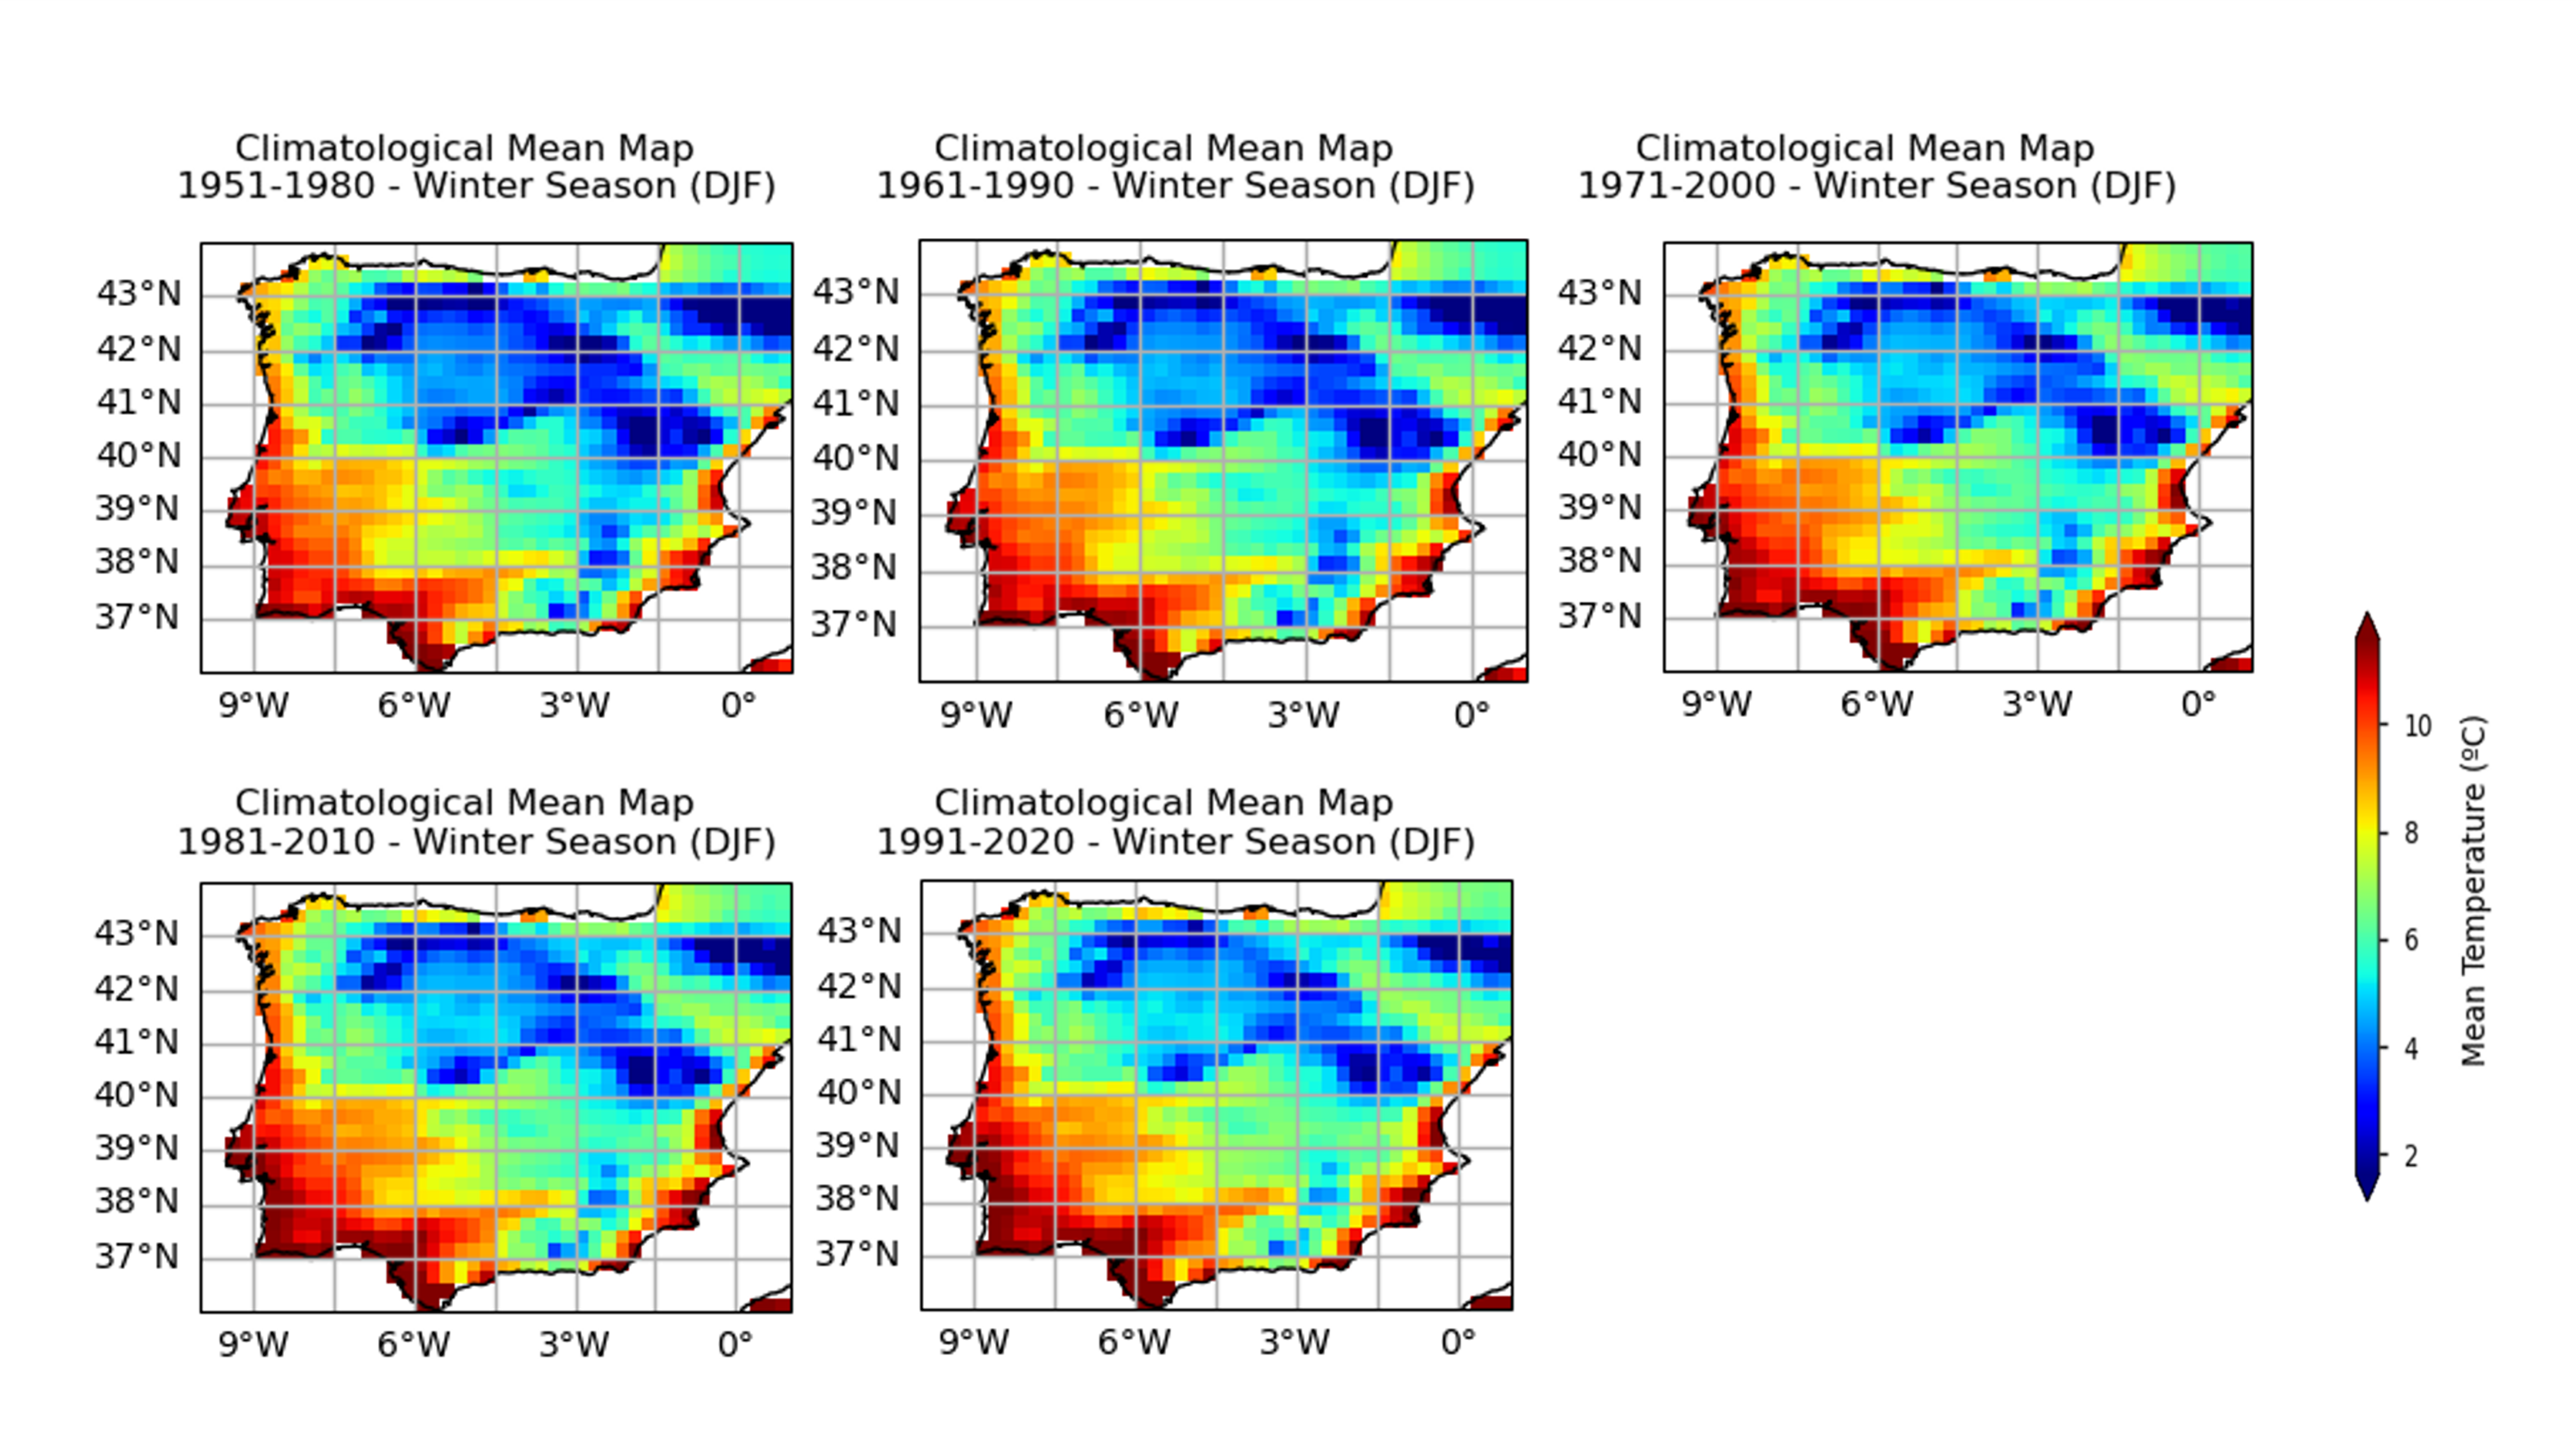

## 1. Define the AoI, search and download E-OBS
Before we begin, we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS and importing the various python libraries that we will need.

### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [1]:
# !pip install cdsapi

### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import download, utils

plt.style.use("seaborn-v0_8-notebook")

### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'in-situ observations' using the search bar. The data we need for this tutorial is the ***E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations***. This catalogue entry provides a daily gridded dataset of historical meteorological observations, covering Europe (land-only), from 1950 to the present. This data is derived from in-situ meteorological stations, made available through the European Climate Assessment & Dataset (ECA&D) project, as provided by National Meteorological and Hydrological Services (NMHSs) and other data-holding institutes. 

E-OBS comprises a set of spatially continuous Essential Climate Variables (ECVs) from the Surface Atmosphere, following the Global Climate Observing System (GCOS) convention, provided as the mean and spread of the spatial prediction ensemble algorithm, at <ins>regular latitude-longitude grid intervals</ins> (at a 0.1° and 0.25° spatial resolution), and covering a long time-period, from 1 January 1950 to present-day. In addition to the land surface elevation, E-OBS includes daily air temperature (mean, maximum and minimum), precipitation amount, wind speed, sea-level pressure and shortwave downwelling radiation. 

The latest E-OBS version, **E-OBSv29.0e**, was released in March 2024 and its main difference from the previous versions is the amount of input data used. Existing networks of synoptic, climatological and (manual) rain-gauge station data are updated with the latest measurements that are received directly from the national or regional meteorological services. 

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use Case, the ensemble mean of air temperature (TG) will be used, considering the last version available. In addition, the ensemble spread of air temperature shall also be used as an indicator of data quality. These can all be selected in the “Download data” tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

* **Product Type:** Ensemble mean  (Ensemble spread)
* **Variable:** Mean temperature
* **Grid resolution:** 0.25  
* **Period:** Full period  
* **Version:** 29.0e  
* **Format:** Zip file (.zip)

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook …

Download data
… having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [3]:
# Define region - AoI
lon_slice = slice(-10, 1)
lat_slice = slice(36, 44)

# Define climatology periods - ToI
years_start = [1951, 1961, 1971, 1981, 1991]
years_stop = [1980, 1990, 2000, 2010, 2020]
colors = ["deepskyblue", "green", "gold", "darkorange", "red"]

# Variable name
varname1 = "tg"

varname2 = "tg_spread"

In [4]:
# Define transform function to reduce downloaded data

def regionalise_and_dayofyear_reindex(ds, lon_slice, lat_slice):
    # Select region
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)

    # 15-day rolling mean
    ds_rolled = ds.rolling(time=15, center=True).mean()

    # Extract periods
    datasets = []
    for year_start, year_stop in zip(years_start, years_stop):
        period = f"{year_start}-{year_stop}"
        ds_masked = ds_rolled.where(
            (ds_rolled["time"].dt.year >= year_start)
            & (ds_rolled["time"].dt.year <= year_stop),
            drop=True,
        )
        datasets.append(
            ds_masked.groupby("time.dayofyear").mean().expand_dims(period=[period])
        )
    ds_dayofyear = xr.merge(datasets)

    # Add season (pick any leap year)
    season = xr.DataArray(
        pd.to_datetime(ds_dayofyear["dayofyear"].values - 1, unit="D", origin="2000"),
    ).dt.season
    return ds_dayofyear.assign_coords(season=("dayofyear", season.values))

In [5]:
# Define request
request = (
    "insitu-gridded-observations-europe",
    {
        "format": "zip",
        "product_type": "ensemble_mean",
        "variable": "mean_temperature",
        "grid_resolution": "0.25deg",
        "period": "full_period",
        "version": "29.0e",
    },
)
ds = download.download_and_transform(
    *request,
    transform_func=regionalise_and_dayofyear_reindex,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
)

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


In [6]:
# Define request
request = (
    "insitu-gridded-observations-europe",
    {
        "format": "zip",
        "product_type": "ensemble_spread",
        "variable": "mean_temperature",
        "grid_resolution": "0.25deg",
        "period": "full_period",
        "version": "29.0e",
    },
)
dss = download.download_and_transform(
    *request,
    transform_func=regionalise_and_dayofyear_reindex,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
)

100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


## 2. Inspect and view data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray.Dataset.

### Basic statistics

To understand better the E-OBS data structure and check the aggregated Daily Mean Temperature (TG), we will first need to retrieve the TG variable from the multidimensional netCDF data structure and calculate the descriptive statistics.

In [7]:
# Specify the old variable name
old_variable_name = 'tg'

# Specify the new variable name, long name and units
new_variable_name = 'TG'
new_long_name = 'Daily Mean Temperature'
new_units = '°C'

# Specify the new variable units>

# Change the variable name and long name
ds  = ds.rename({old_variable_name: new_variable_name})
ds[new_variable_name].attrs['long_name'] = new_long_name
ds[new_variable_name].attrs['units'] = new_units

ds

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 44, dayofyear: 366, period: 5)
Coordinates:
  * latitude   (latitude) float64 36.12 36.38 36.62 36.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 -9.875 -9.625 -9.375 ... 0.375 0.625 0.875
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * period     (period) object '1951-1980' '1961-1990' ... '1991-2020'
    season     (dayofyear) object dask.array<chunksize=(366,), meta=np.ndarray>
Data variables:
    TG         (period, dayofyear, latitude, longitude) float32 dask.array<chunksize=(5, 366, 32, 44), meta=np.ndarray>
Attributes:
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Mar 22 10:08:04 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

In [9]:
# Specify the old variable name
old_variable_name = 'tg'

# Specify the new variable name, long name and units
new_variable_name = 'TG Spread'
new_long_name = 'Daily Mean Temperature Ensemble Spread'
new_units = '°C'

# Specify the new variable units>

# Change the variable name and long name
dss  = dss.rename({old_variable_name: new_variable_name})
dss[new_variable_name].attrs['long_name'] = new_long_name
dss[new_variable_name].attrs['units'] = new_units

dss

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 44, dayofyear: 366, period: 5)
Coordinates:
  * latitude   (latitude) float64 36.12 36.38 36.62 36.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 -9.875 -9.625 -9.375 ... 0.375 0.625 0.875
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * period     (period) object '1951-1980' '1961-1990' ... '1991-2020'
    season     (dayofyear) object dask.array<chunksize=(366,), meta=np.ndarray>
Data variables:
    TG Spread  (period, dayofyear, latitude, longitude) float32 dask.array<chunksize=(5, 366, 32, 44), meta=np.ndarray>
Attributes:
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Mar 22 10:09:48 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

We can see from the data structure that our variable, 'tg', is already stored in a four-dimensional array with dimensions: 5 time periods in 'period', 366 days in 'dayofyear', 36 steps in 'latitude', and 24 steps in 'longitude'. This is because the toolbox provides an already post-processed output with the values calculated using the transformer function. In this use case, the following 30-years climatological periods are considered, as per the guidelines from the World Meteorological Organization (WMO):

- 1951 to 1980
- 1961 to 1990
- 1971 to 2000
- 1981 to 2010
- 1991 to 2020

This reduces the amount of data to be processed and stored locally, faclitating the next steps. Let's inspect the data and compute the basic descriptive statistics of each period and print them in tabular form.

In [10]:
# Define ToI dictionary
periods_dict = {
    0: '1951-1980',
    1: '1961-1990',
    2: '1971-2000',
    3: '1981-2010',
    4: '1991-2020'}

# Calculate descriptive statistics by ToI

tg_nr = []
tg_mean = []
tg_max = []
tg_min = []
tg_std = []

for key in periods_dict.keys():
    
    tg = ds['TG'].values[key]
    tg = tg[~np.isnan(tg)]
    
    tg_nr.append(len(tg))
    tg_mean.append(tg.mean())
    tg_max.append(tg.max())
    tg_min.append(tg.min())
    tg_std.append(tg.std())
    
# Create a DataFrame from the dictionary and arrays
tg_data = {
    'period': list(periods_dict.values()),
    'number': tg_nr,
    'mean': tg_mean,
    'maximum': tg_max,
    'minimum': tg_min,
    'st.deviation': tg_std,
}
tg_data = pd.DataFrame(tg_data)

tg_data

period  number       mean    maximum   minimum  st.deviation
0  1951-1980  363804  13.025599  27.732910 -4.748500      6.323084
1  1961-1990  363804  13.162615  27.563332 -5.176666      6.337932
2  1971-2000  363804  13.351327  27.879154 -4.002000      6.283964
3  1981-2010  363804  13.792176  28.452620 -4.079143      6.439911
4  1991-2020  363804  14.089884  29.024021 -2.791833      6.497530

In [12]:
# Define ToI dictionary
periods_dict = {
    0: '1951-1980',
    1: '1961-1990',
    2: '1971-2000',
    3: '1981-2010',
    4: '1991-2020'}

# Calculate descriptive statistics by ToI

tgs_nr = []
tgs_mean = []
tgs_max = []
tgs_min = []
tgs_std = []

for key in periods_dict.keys():
    
    tgs = dss['TG Spread'].values[key]
    tgs = tgs[~np.isnan(tgs)]
    
    tgs_nr.append(len(tgs))
    tgs_mean.append(tgs.mean())
    tgs_max.append(tgs.max())
    tgs_min.append(tgs.min())
    tgs_std.append(tgs.std())
    
# Create a DataFrame from the dictionary and arrays
tgs_data = {
    'period': list(periods_dict.values()),
    'number': tgs_nr,
    'mean': tgs_mean,
    'maximum': tgs_max,
    'minimum': tgs_min,
    'st.deviation': tgs_std,
}
tgs_data = pd.DataFrame(tgs_data)

tgs_data

period  number      mean   maximum   minimum  st.deviation
0  1951-1980  363804  1.893827  3.785200  0.543422      0.457626
1  1961-1990  363804  1.854728  3.976733  0.488200      0.479654
2  1971-2000  363804  1.811129  3.793916  0.502089      0.471992
3  1981-2010  363804  1.785803  3.709156  0.515711      0.496204
4  1991-2020  363804  1.807398  3.601666  0.515689      0.477967

As we can see from the descriptive statistics, the most recent climatological period is characterized by higher average temperatures - in the Iberian Peninsula, the mean annual TG between 1991 and 2020 is almost 1,0⁰C above the equivalent in 1951 to 1980, while the annual maximum TG has a positive difference by more than 1,5⁰C, and the annual minimum TG is characterized by a smaller, albeit positive, 0,5⁰C difference. To further explore these findings, let's print the spatial patterns of TG over the AoI.

## 3. Plot the climatology for alternative 30-year periods

To evaluate the spatial patterns of E-OBS Daily Mean Temperatures, we will first need to define some helper functions to calculate the climatology and the probability density function.

#### Calculation of the Climatological Mean

With the subsets per period already created, now it is time to calculate the climatological mean for each one. Here, the calculation of the annual mean TG map for each day of the year (DOY) is done, while considering a 15-days Simple Moving Average (SMA), in  order to smooth the inter-days varibility.

In [11]:
# Define helper functions to plot maps
def plot_maps(da, **kwargs):
    facet = da.plot.pcolormesh(subplot_kws={"projection": ccrs.PlateCarree()}, **kwargs)
    for ax in facet.axs.flatten():
        ax.set_extent(
            [lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop],
            crs=ccrs.PlateCarree(),
        )
        ax.coastlines(lw=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
   
    return facet

# Define helper functions to plot PDF
def plot_pdf(da, colors=None, **kwargs):
    lines = []
    for i, (period, da) in enumerate(da.groupby("period")):
        hist, bin_edges = np.histogram(
            da, bins=np.linspace(da.min(), da.max(), 50), density=True
        )
        da_hist = xr.DataArray(
            hist, coords={"bins": (bin_edges[1:] + bin_edges[:-1]) / 2}
        )
        da_hist["bins"].attrs = da.attrs
        da_hist.attrs["long_name"] = "Probability Density"
        if colors is not None:
            kwargs["color"] = colors[i]
        lines.append(da_hist.plot.line(x="bins", label=period, **kwargs))
    return lines

#### Mean Map of the 5 subsets, for the defined AoI

… having defined and calculated the climatological mean of each subset, we can now plot the annual mean TG map of the selected subsets.

### Plot TG per ToI


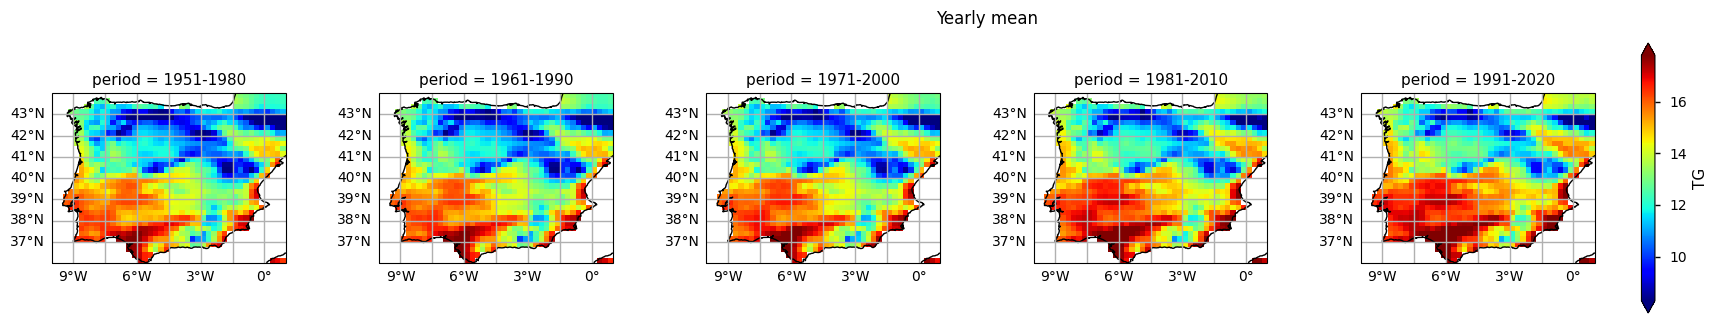

In [12]:
facet = plot_maps(
    ds['TG'].mean("dayofyear"), col="period", cmap="jet", robust=True, col_wrap = 6
)

facet.fig.suptitle("Yearly mean", y=1, va="bottom")
facet.fig.subplots_adjust(hspace=0.4,wspace=0.4)

### Plot TG Spread per ToI


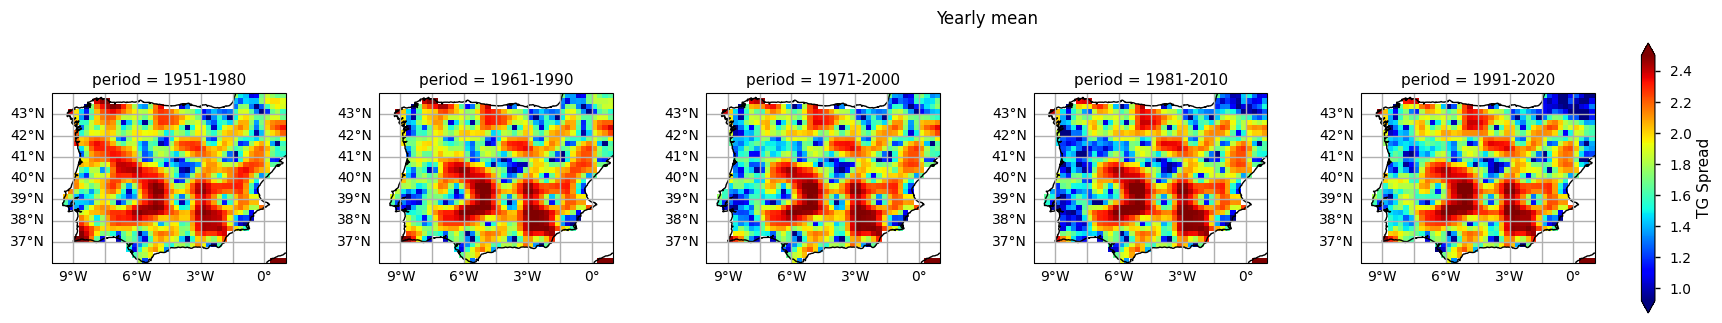

In [13]:
facet = plot_maps(
    dss['TG Spread'].mean("dayofyear"), col="period", cmap="jet", robust=True, col_wrap = 6
)

facet.fig.suptitle("Yearly mean", y=1, va="bottom")
facet.fig.subplots_adjust(hspace=0.4,wspace=0.4)

The results show already disclose some spatial patterns of the annual statistics summarised before: for instance, the increase of TG is more pronounced in southernmost part of the AoI, compared to the North. In addition, there is also a mean annual TG increase along the north-western coast of Portugal.

## 4. Calculate the probability density function (PDF) of each alternative 30-year period

To complement the statistics and the maps of the annual mean TG over the Iberian Peninsula, it is also useful to consider the full distribution of TG values which is a function of space and time. The PDF is useful to this effect, as is shows how frequent certain values are in a given period. In the following plot, we compare the PDF across the five climatology periods to emphasise how these frequencies have been changing.

### Plot PDF and PDF per TOI, respectively

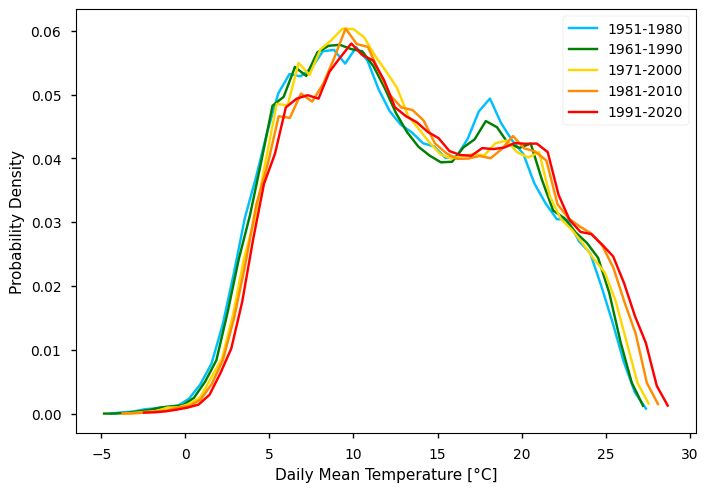

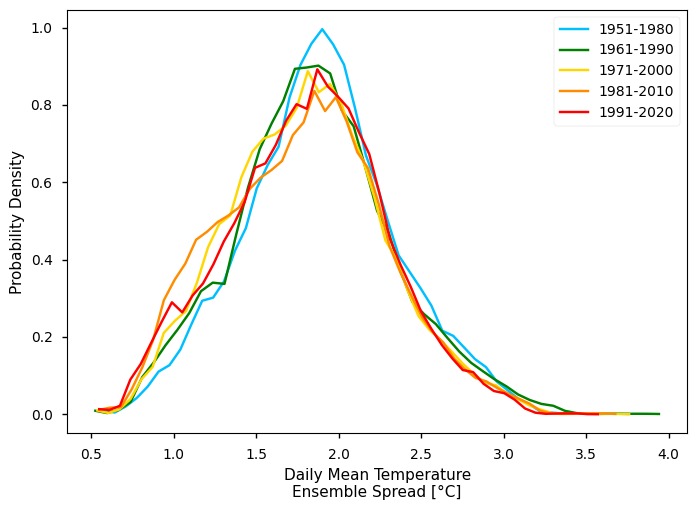

In [14]:
# Plot PDF per ToI
fig, ax = plt.subplots(1, 1)
lines = plot_pdf(ds['TG'], colors=colors, ax=ax, add_legend=False)
plt.legend()

# Plot PDF Spread per ToI
fig, ax = plt.subplots(1, 1)
lines = plot_pdf(dss['TG Spread'], colors=colors, ax=ax, add_legend=False)
plt.legend()

From the plot, we can clearly see a shift in the distribution towards the right - i.e., mean annual TG values and increasing along the overall amplitude of TG observed, while the most extreme values seem to deviate more than the minimum. Interestingly, we see a suggestion of bi-modal pattern in TG. Conversely, the TG Spread shows larger values in earlier climatological periods - this agrees with the consistent increase of in-situ data available, along time.

## 5. Calculate and plot seasonal PDFs and the climatological season maps  

To take the analysis further, it is also useful to proceed with the calculation of seasonal climatologies. In this case the Time of Interest (ToI) will consider only the coolest and warmer seasons of the year, i.e., Winter (Decembre, January, and February - DJF) and Summer (June, July, and August - JJA). In both cases, we will plot their PDF and maps for all the five periods.

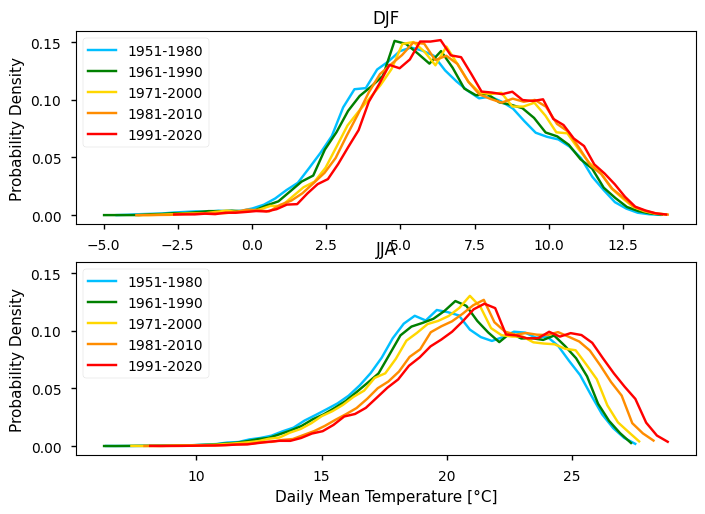

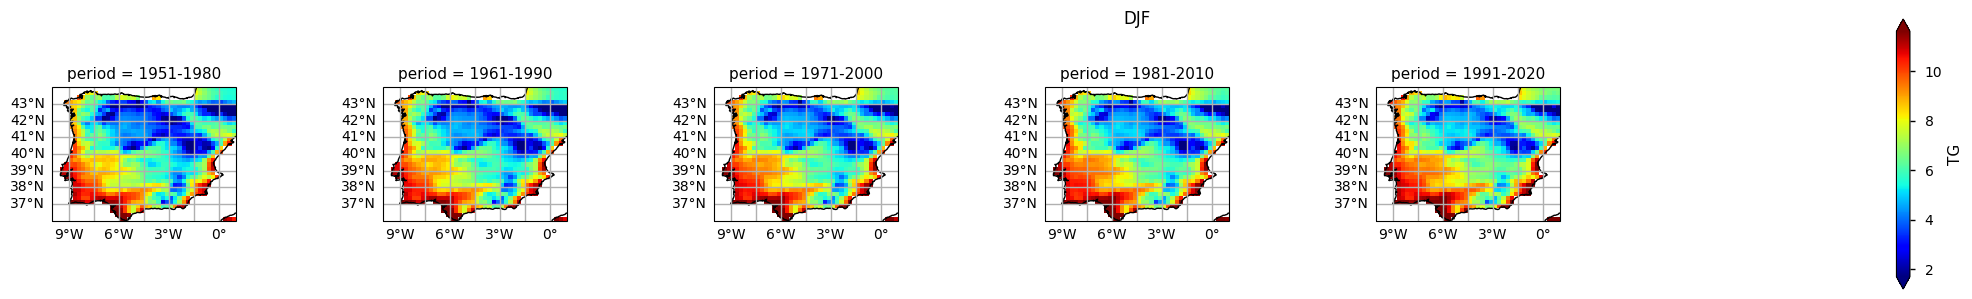

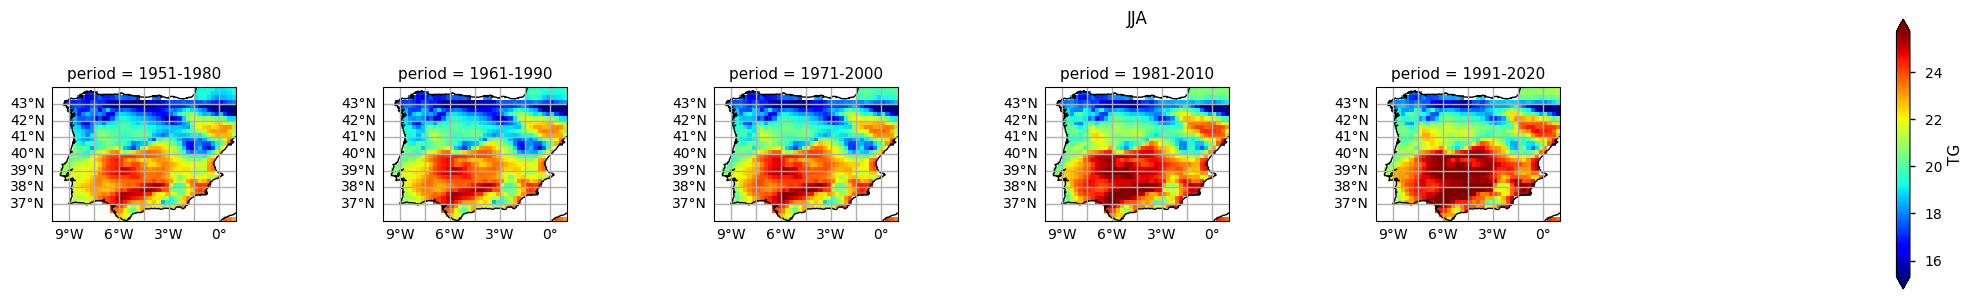

In [16]:
# Calculate and plot PDF and Maps per ToI and season
fig, axes = plt.subplots(2, 1, sharey=True)
for i, (season, ax) in enumerate(zip(["DJF", "JJA"], axes)):
    facet = plot_maps(
        ds['TG'].where(ds["season"] == season).mean("dayofyear"),
        col="period",
        cmap="jet",
        robust=True,
        col_wrap = 7,
    )
    facet.fig.suptitle(season)
    facet.fig.subplots_adjust(hspace=0.8,wspace=0.8)

    plot_pdf(
        ds['TG'].where(ds["season"] == season),
        colors=colors,
        ax=ax,
        add_legend=False,
    )
    
    if not i:
        ax.set_xlabel("")
    ax.set_title(season)
    ax.legend()

## 6. Calculate seasonal probability density function of each alternative 30-year period


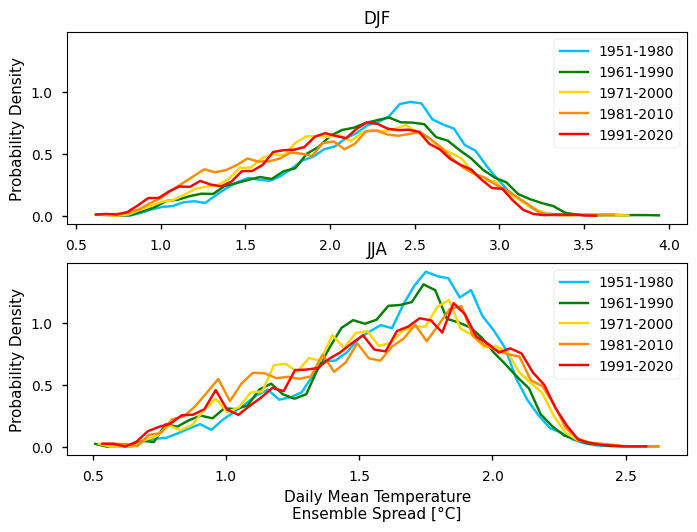

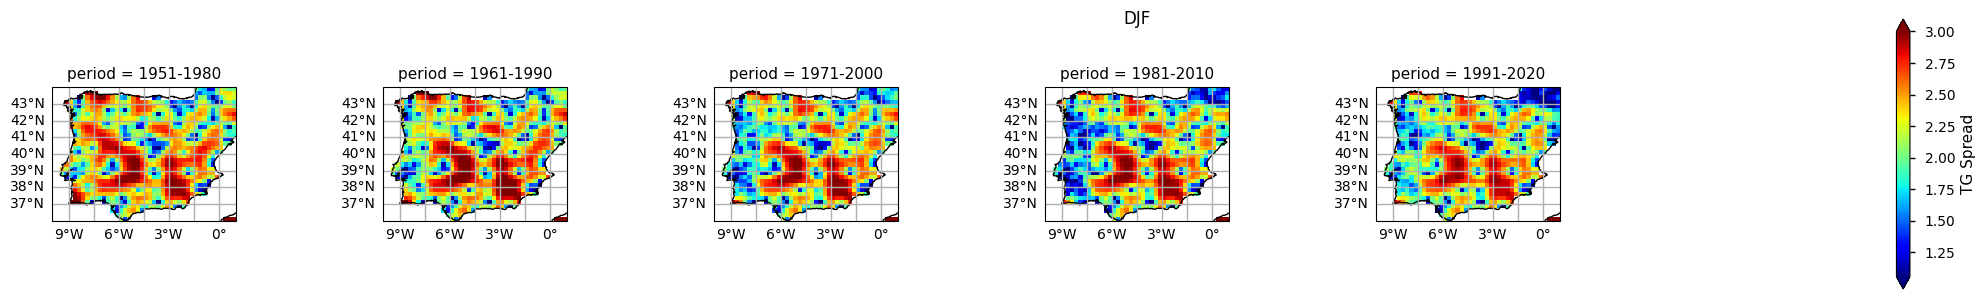

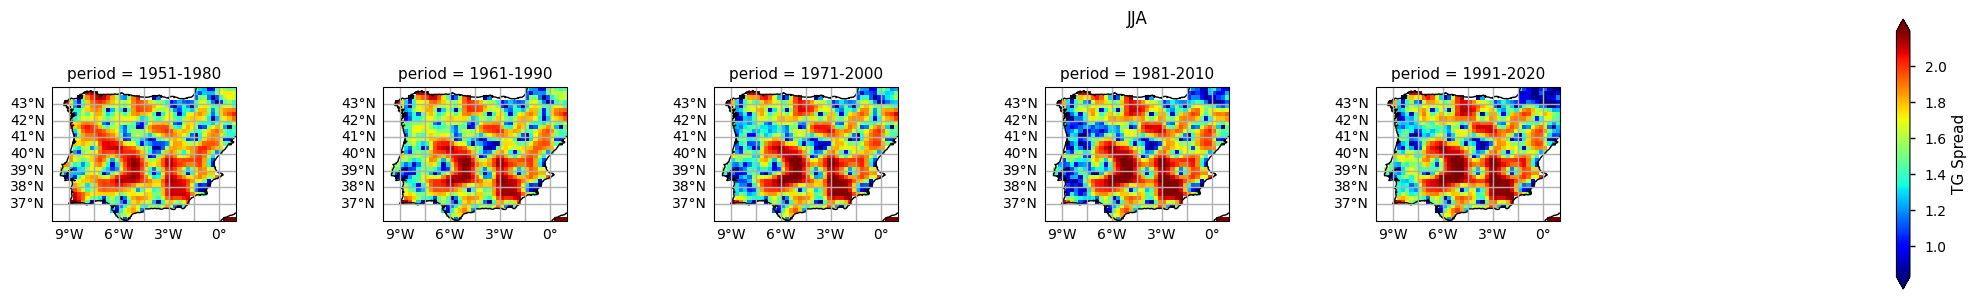

In [17]:
fig, axes = plt.subplots(2, 1, sharey=True)
for i, (season, ax) in enumerate(zip(["DJF", "JJA"], axes)):
    facet = plot_maps(
        dss['TG Spread'].where(dss["season"] == season).mean("dayofyear"),
        col="period",
        cmap="jet",
        robust=True,
        col_wrap = 7,
    )
    facet.fig.suptitle(season)
    facet.fig.subplots_adjust(hspace=0.8,wspace=0.8)

    plot_pdf(
        dss['TG Spread'].where(dss["season"] == season),
        colors=colors,
        ax=ax,
        add_legend=False,
    )
    
    if not i:
        ax.set_xlabel("")
    ax.set_title(season)
    ax.legend()

In the above plots, we can see a dissimilar spatial pattern between seasonal changes: in the Winter, the higher temperature changes are clustered along the Atlantic littoral zones, namely along the Portuguese western and the Spanish coasts; by contrast, in the Summer, the littoral does no increase as much and the hotspot for TG increase is shifted towards southern inland Spain. In complement, we can see here also contrasts: while the PDF results from the most recent periods show a positive TG change, this trend is much greater during the Summer when the full PDF is shifting upwards in the temperature range. By contrast, during Winter, the PDF has a lower shift that is significative over the higher temperature values only.

These findings show how the positive signal detected in the TG statistics over the Iberian Peninsula are, in fact, insufficient to disclose the full temporal and spatial variability of changes in the local and regional climate. This analysis successfully showcases the ability of using the E-OBS data to reveal such patterns and highlight where and when changes are greater, in more detail.

Nevertheless, TG ensemble spread shows inhomogeneous spatial patterns that arise from the irregular density of in-situ stations available, across the region. Indeed, this inhomogeneity indicates that EOBS accuracy is location-dependent. As described in this dataset's documentation, the usage of this dataset should be with caution in interpreting trends and extremes, considering the potential limitations in accuracy and completeness, especially in regions with sparse observational data (Cornes et al., 2018). Furthermore, potential biases should be considered from these techniques and consider the spatial variability in data density when interpreting results. For instance, it may also be influenced by factors such as changes in observational practices, station location shifts, or urbanization effects, which can introduce uncertainties in the interpretation of long-term trends.

As an indicator of the confidence intervals associated with individual grid cells, the ensemble spread may provide insights into the reliability of data in specific locations, aiding in the assessment of uncertainties (Carvalho, Cardoso Pereira, and Rocha, 2021).

## 7. Main takeaways

Observational-based gridded datasets, such as E-OBS, are relatively quick to download and analyse, due to its reduced dimensionallity (single surface level, daily values) and having a multi-decadal temporal coverage it offers an important source for climate change monitoring.
Being the result of spatial interpolation techniques, E-OBS is subject to the inherent limitations of having inhomogenous coverage of in situ stations.
As a result, 
- There is a visible difference between air temperature climatologies from different periods, as the earliest 30-years subset (1951-1980) shows an overall “colder” annual mean air temperature, while the latest 30-years subset (1991-2020) shows the “warmest” one, over the Iberian Peninsula. *Carvalho, Cardoso Pereira, and Rocha (2021)* conclusion supports this alignment, in which the authors observed  significant increases in mean, maximum, and minimum surface temperatures for the medium-term (2046–2065) and long-term (2081–2100) futures.

- In addition, these changes are progressive along the time dimension, i.e., each climatology reveals an increased mean annual temperature, compared to the 10-years previous one. 

- These deviations aren’t the same across all of the statistical distribution, i.e., there are greater upwards deviations in the upper values of the mean annual air temperature, when compared with the lowest ones. The Probability Density Function (PDF) graphs thus show that there is a shift towards the right but also changes in the simmetry with larger increase of warmer temperatures.

- These changes are also visible at seasonal level, with less variance on the Winter Season  PDF (DJF) when compared with the Summer Season PDF (JJA).

- Furthermore, there is an evident spatial pattern regarding the changes observed on the Climatological Mean Maps, with significant differences between the south and westernmost parts of the Iberia Peninsula (warmer), compared to the interior and northernmost regions (colder). These spatial variations, aligns with *Cornes et al. (2018)*, where was analysed the ensemble dataset's spatial variation, influenced by station density, in which supports the observations of spatial patterns in temperature changes over the Iberian Peninsula. 

- Whenever using climatological data for their application, the user should carefully consider that the results are sensible to the chosen time of interest. This is especially true to applications which are highly sensitive to air temperature differences (e.g., estimation of energy needs, analysis of extreme events based on percentiles).

## 8. References:


1. World Meteorological Organization (WMO) Guidelines on the Calculation of Climate Normals: https://library.wmo.int/index.php?lvl=notice_display&id=20130

2. E-OBS daily gridded observations for Europe from 1950 to present: Product user guide: https://confluence.ecmwf.int/display/CKB/E-OBS+daily+gridded+observations+for+Europe+from+1950+to+present%3A+Product+user+guide

3. Research paper describing the E-OBS ensemble version: Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. (Atmospheres), 123. doi:10.1029/2017JD028200

4. Carvalho, D., S. Cardoso Pereira, and A. Rocha. 2021. “Future Surface Temperature Changes for the Iberian Peninsula According to EURO-CORDEX Climate Projections.” Climate Dynamics 56 (1–2): 123–38. https://doi.org/10.1007/S00382-020-05472-3.